In [4]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from xgboost import XGBRegressor

df = pd.read_csv('data/up.csv')

In [5]:
X = df[['AreaSQM', 'Floors', 'Bedrooms', 'Yard', 'Bathrooms']]
y = df[['Price_Php_M']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [6]:
scaler = StandardScaler()

X_test_scaled = scaler.fit_transform(X_test)
X_train_scaled = scaler.transform(X_train)

# Convert pandas dataframes to tensors
X_train_tensor = tf.convert_to_tensor(X_train_scaled, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train.values.tolist(), dtype=tf.float32)

# Initialize a weight and a bias
W = tf.Variable(tf.random.normal([X_train.shape[1], 1]), name='weight')
b = tf.Variable(tf.random.normal([1]), name='bias')

In [7]:
# Define a linear regression model
def linear_regression(x):
    return tf.matmul(x, W) + b

# Define a loss function (mean squared error)
def mean_square(y_pred, y_true):
    return tf.reduce_mean(tf.square(y_pred - y_true))

In [8]:
# Define an optimizer
optimizer = tf.optimizers.SGD(0.01)

# Run the optimization process in a loop
for i in range(1000):
    # Wrap computation inside a GradientTape for automatic differentiation
    with tf.GradientTape() as g:
        pred = linear_regression(X_train_tensor)
        loss = mean_square(pred, y_train_tensor)

    # Compute gradients
    gradients = g.gradient(loss, [W, b])

    # Update W and b following gradients
    optimizer.apply_gradients(zip(gradients, [W, b]))

### Create and train Sequential Model

In [9]:
# Sequential model
sequential_model = tf.keras.models.Sequential()

# Add layers to the sequential model
sequential_model.add(tf.keras.layers.Dense(5, input_dim=X_train_scaled.shape[1], activation='relu'))

# Add an output layer
sequential_model.add(tf.keras.layers.Dense(1, activation='linear'))

# Compile the model
sequential_model.compile(loss='mean_squared_error', optimizer='sgd')

# Train the model
sequential_model.fit(X_train_scaled, y_train, epochs=100, batch_size=10, verbose=1)

Epoch 1/100
5/5 [==============================] - 0s 2ms/step - loss: 92.0103
Epoch 2/100
5/5 [==============================] - 0s 1ms/step - loss: 31.4147
Epoch 3/100
5/5 [==============================] - 0s 2ms/step - loss: 12.7301
Epoch 4/100
5/5 [==============================] - 0s 1ms/step - loss: 8.7370
Epoch 5/100
5/5 [==============================] - 0s 2ms/step - loss: 5.5409
Epoch 6/100
5/5 [==============================] - 0s 2ms/step - loss: 3.9360
Epoch 7/100
5/5 [==============================] - 0s 2ms/step - loss: 2.6645
Epoch 8/100
5/5 [==============================] - 0s 2ms/step - loss: 2.3602
Epoch 9/100
5/5 [==============================] - 0s 1ms/step - loss: 2.2837
Epoch 10/100
5/5 [==============================] - 0s 2ms/step - loss: 2.0706
Epoch 11/100
5/5 [==============================] - 0s 2ms/step - loss: 1.9613
Epoch 12/100
5/5 [==============================] - 0s 2ms/step - loss: 2.1545
Epoch 13/100
5/5 [==============================] - 0s 2ms

### Create and Predict Models

In [10]:
# Create models
linear_model = LinearRegression()
xgboost = XGBRegressor(objective ='reg:squarederror')

# Train the models using the training sets
linear_model.fit(X_train_scaled, y_train)
xgboost.fit(X_train_scaled, y_train)

# Make predictions using the testing set
linear_regression_predict = linear_model.predict(X_test_scaled)
xgboost_predict = xgboost.predict(X_test_scaled)

# X_test_tensor = tf.convert_to_tensor(X_test_scaled, dtype=tf.float32)
# tensorflow_predict = linear_regression(X_test_tensor)

E:\Source\python\datascience\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
E:\Source\python\datascience\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
E:\Source\python\datascience\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
E:\Source\python\datascience\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_in

### Evaluate Models

In [11]:
# R squared score for each prediction
print('Linear Regression R^2: %.2f' % metrics.r2_score(y_test, linear_regression_predict))
print('XGBoost R^2: %.2f' % metrics.r2_score(y_test, xgboost_predict))
print('Linear regression with Tensorflow R^2: %.2f' % metrics.r2_score(y_test, sequential_model.predict(X_test_scaled)))

Linear Regression R^2: 0.96
XGBoost R^2: 0.93
1/1 [==============================] - 0s 75ms/step
Linear regression with Tensorflow R^2: 0.94


### Plot Predictions

1/1 [==============================] - 0s 18ms/step


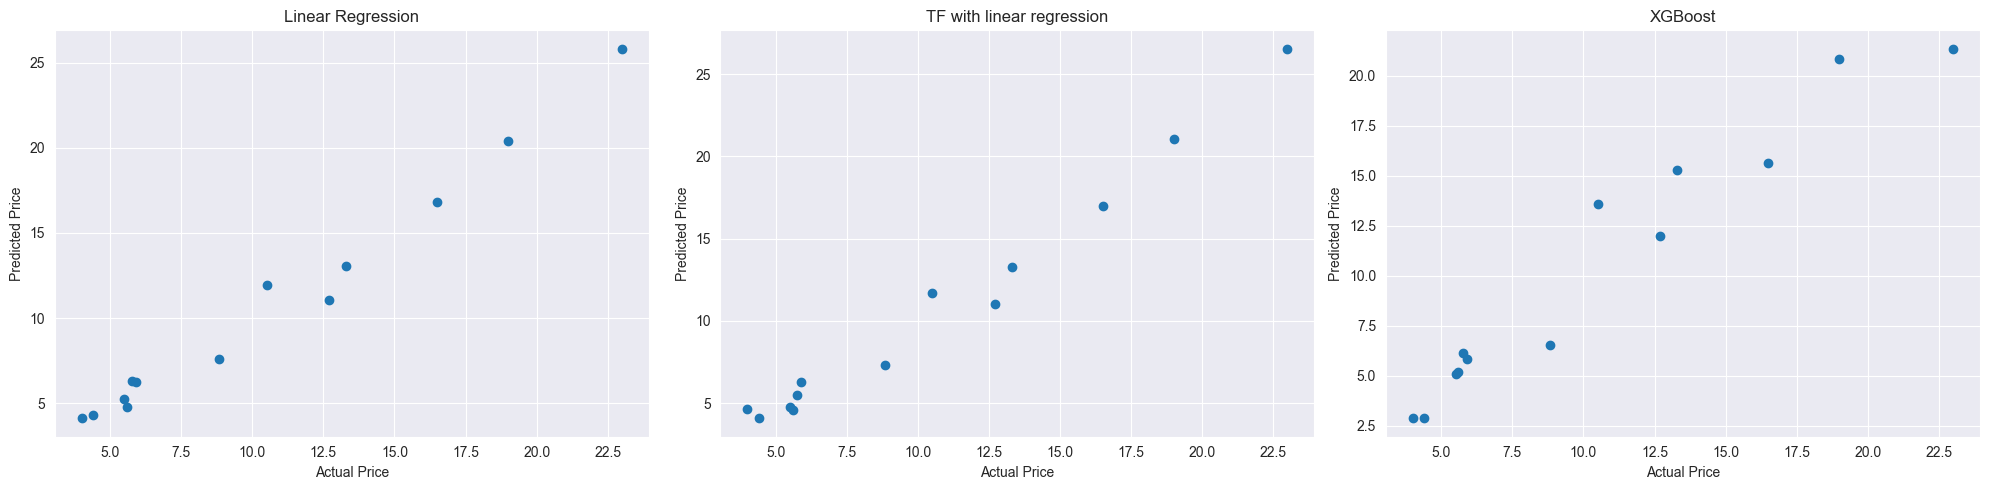

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
plt.scatter(y_test, linear_regression_predict)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Linear Regression')

plt.subplot(1, 3, 2)
plt.scatter(y_test, sequential_model.predict(X_test_scaled))
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('TF with linear regression')

plt.subplot(1, 3, 3)
plt.scatter(y_test, xgboost_predict)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('XGBoost')

plt.tight_layout()
plt.show()

<Axes: xlabel='Price_Php_M'>

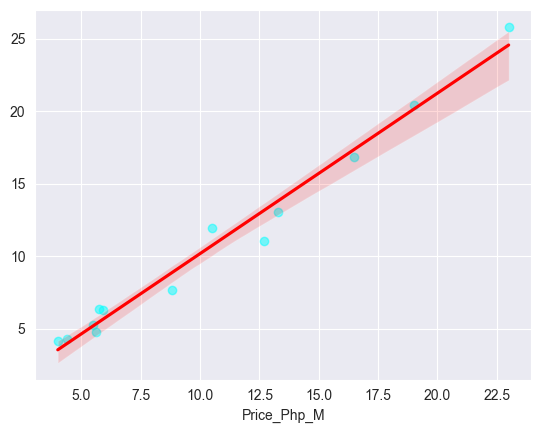

In [13]:
import seaborn as sb

sb.regplot(x= y_test,
           y= linear_regression_predict,
           scatter_kws= {"color": "cyan", "alpha": 0.5},
           line_kws= {"color": "red"}
           )

<Axes: xlabel='Price_Php_M'>

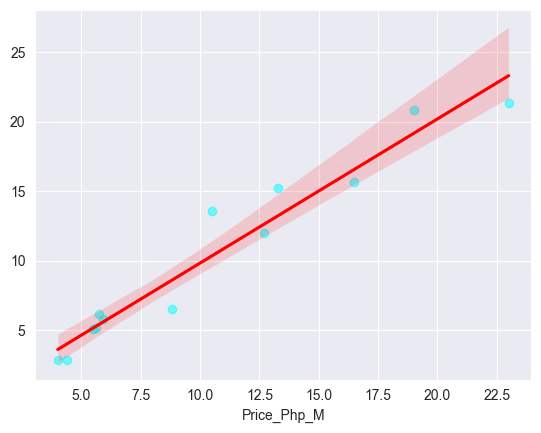

In [14]:
sb.regplot(x= y_test,
           y= xgboost_predict,
           scatter_kws= {"color": "cyan", "alpha": 0.5},
           line_kws= {"color": "red"}
           )

1/1 [==============================] - 0s 19ms/step


<Axes: xlabel='Price_Php_M'>

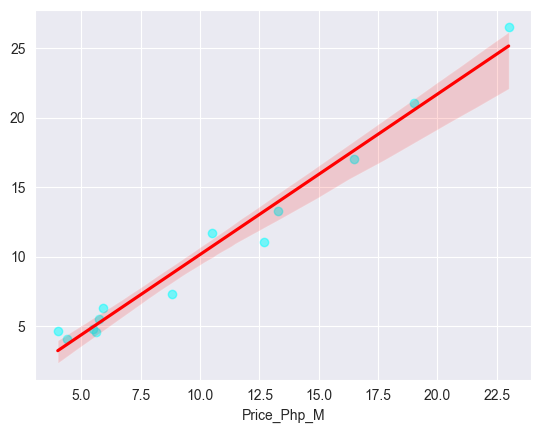

In [15]:
sb.regplot(x= y_test,
           y= sequential_model.predict(X_test_scaled),
           scatter_kws= {"color": "cyan", "alpha": 0.5},
           line_kws= {"color": "red"}
           )

### Save Models

In [26]:
from joblib import dump

dump(linear_model, 'models/linear_regression.joblib')
xgboost.save_model('models/xgboost.json')
sequential_model.save('models/sequential.keras')

### Load Trained Models

In [98]:
from joblib import load

trained_linear_model = load('models/linear_regression.joblib')

trained_xgboost = XGBRegressor()
trained_xgboost.load_model('models/xgboost.json')

trained_sequential_model = tf.keras.models.load_model('models/sequential.keras')

### Load, Clean, and Normalize the Other Dataset

In [99]:
df_other = pd.read_csv('data/kaggle/output.csv')
df_other.drop_duplicates()

X_other = df_other[['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']]
y_other = df_other[['price']]

X_other_train, X_other_test, y_other_train, y_other_test = train_test_split(X_other, y_other, test_size=0.2)

X_other_test_scaled = scaler.fit_transform(X_other_test)
X_other_train_scaled = scaler.transform(X_other_train)

### Retrain the models with the other dataset

In [100]:
trained_linear_model.fit(X_other_train_scaled, y_other_train)
trained_xgboost.fit(X_other_train_scaled, y_other_train)
#sequential_model.fit(X_other_train_scaled, y_other_train, epochs=100, batch_size=10, verbose=1)

E:\Source\python\datascience\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
E:\Source\python\datascience\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
E:\Source\python\datascience\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
E:\Source\python\datascience\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_in

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### Evaluate the models with the other dataset

In [101]:
print('Trained Linear Regression R^2: %.2f' % metrics.r2_score(y_other_test, trained_linear_model.predict(X_other_test_scaled)))
print('Trained XGBoost R^2: %.2f' % metrics.r2_score(y_other_test, trained_xgboost.predict(X_other_test_scaled)), end='\n\n')

print('Trained Linear Regression train score: ', trained_linear_model.score(X_other_train_scaled, y_other_train))
print('Trained Linear Regression test score: ', trained_linear_model.score(X_other_test_scaled, y_other_test), end='\n\n')

print('Trained XGBoost train score: ', trained_xgboost.score(X_other_train_scaled, y_other_train))
print('Trained XGBoost test score: ', trained_xgboost.score(X_other_test_scaled, y_other_test))

Trained Linear Regression R^2: -2335118725437294641152.00
Trained XGBoost R^2: 0.07

Trained Linear Regression train score:  0.3446537968582154
Trained Linear Regression test score:  -2.3351187254372946e+21

Trained XGBoost train score:  0.9157557171672912
Trained XGBoost test score:  0.07062290020142525


### Cross Validation

In [94]:
from sklearn.model_selection import cross_val_score

cross_valid_linear = cross_val_score(trained_linear_model, X_other_train_scaled, y_other_train, cv=5, scoring='r2')
cross_valid_xgboost = cross_val_score(trained_xgboost, X_other_train_scaled, y_other_train, cv=5, scoring='r2')

print('Trained Linear Regression Cross Validation R^2: %.2f' % cross_valid_linear.mean())
print('Trained XGBoost Cross Validation R^2: %.2f' % cross_valid_xgboost.mean())

E:\Source\python\datascience\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
E:\Source\python\datascience\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
E:\Source\python\datascience\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
E:\Source\python\datascience\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_in

Trained Linear Regression Cross Validation R^2: 0.18
Trained XGBoost Cross Validation R^2: 0.13


E:\Source\python\datascience\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
E:\Source\python\datascience\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
E:\Source\python\datascience\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
E:\Source\python\datascience\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_in

### Save Models

In [97]:
dump(trained_linear_model, 'models/linear_regression.joblib')
trained_xgboost.save_model('models/xgboost.json')

### Plot Predictions with Line regression

<Axes: xlabel='price'>

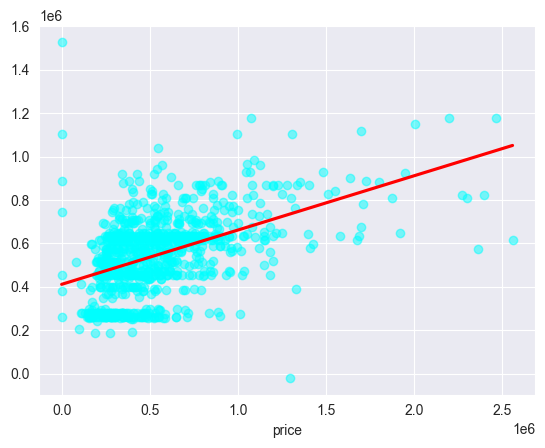

In [95]:
sb.regplot(x= y_other_test,
           y= trained_linear_model.predict(X_other_test_scaled),
           scatter_kws= {"color": "cyan", "alpha": 0.5},
           line_kws= {"color": "red"},
           ci= None
           )

<Axes: xlabel='price'>

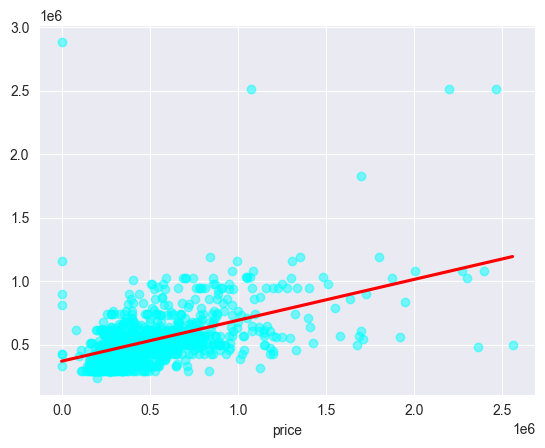

In [96]:
sb.regplot(x= y_other_test,
           y= trained_xgboost.predict(X_other_test_scaled),
           scatter_kws= {"color": "cyan", "alpha": 0.5},
           line_kws= {"color": "red"},
           ci= None
           )

### Plot Learning Curves

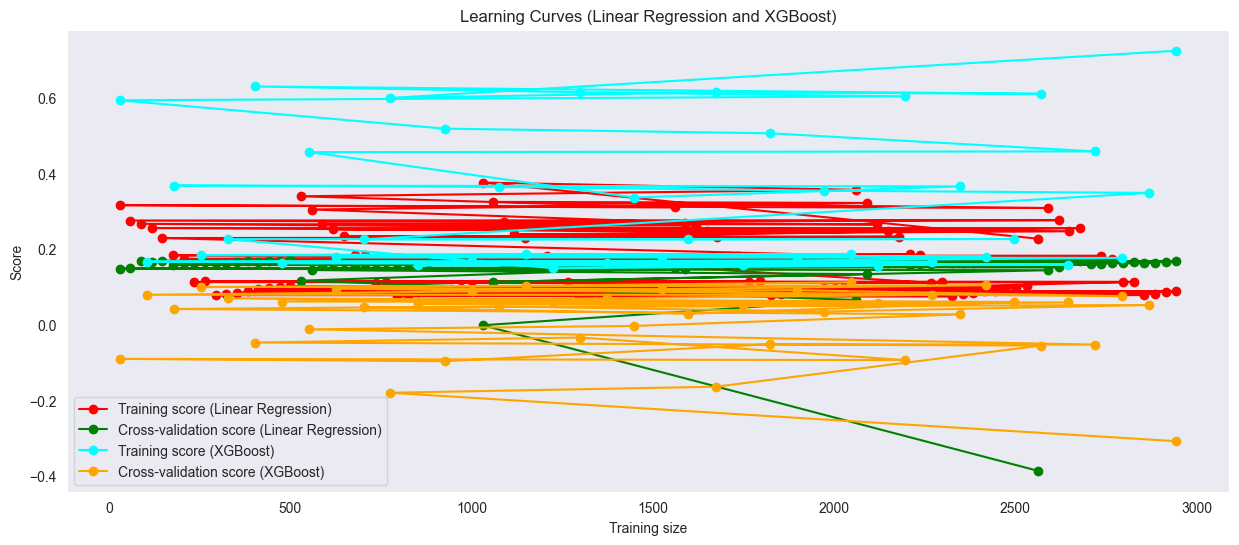

In [82]:
import numpy as np
from sklearn.model_selection import learning_curve

plt.figure(figsize=(15, 6))

train_sizes, train_scores, test_scores = learning_curve(
        trained_linear_model,
        X_other_train_scaled,
        y_other_train,
        cv=5, scoring='r2', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 100)
    )

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

train_sizes = list(set(train_sizes))

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label=f"Training score (Linear Regression)")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label=f"Cross-validation score (Linear Regression)")

train_sizes, train_scores, test_scores = learning_curve(
        trained_xgboost,
        X_other_train_scaled,
        y_other_train,
        cv=5, scoring='r2', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 40)
    )

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

train_sizes = list(set(train_sizes))

plt.plot(train_sizes, train_scores_mean, 'o-', color="cyan", label=f"Training score (XGBoost)")
plt.plot(train_sizes, test_scores_mean, 'o-', color="orange", label=f"Cross-validation score (XGBoost)")

plt.xlabel("Training size")
plt.ylabel("Score")
plt.legend(loc="best")
plt.title("Learning Curves (Linear Regression and XGBoost)")
plt.grid()
plt.show()